In [920]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from pandas import DataFrame
import pickle, random
from tqdm import tqdm
from scipy.spatial import KDTree

In [921]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

In [922]:
#df0 = pd.read_csv('../spreadsheets/rlhf_1064.csv')
df0 = pd.read_csv('../spreadsheets/rlhf_159nlp2.csv')

In [923]:
df0.head()

,Unnamed: 0,sma-05 (entry),sma-07 (entry),sma-25 (entry),sma-compare (entry),is_short,action,imit-action,nlpreds,reward
0,0,0.008822,0.008803,0.008324,0,0,go_short,go_long,go_short,0.500560
1,1,0.009810,0.009803,0.009696,0,0,go_short,go_long,go_short,0.374019
2,2,0.009770,0.009767,0.009703,0,0,go_short,go_long,go_short,0.629307
3,3,0.009914,0.009921,0.010024,1,0,go_short,go_long,go_short,0.310551
4,4,0.010094,0.010069,0.009925,0,0,go_short,go_long,go_short,0.425579


In [924]:
df0['nlpreds'].value_counts()

nlpreds
do_nothing    4320
go_short       196
Name: count, dtype: int64

In [925]:
def prep_data(df: DataFrame) -> DataFrame:
    train_data = pd.DataFrame()
    for col in df.columns:
        col_name = col.split(' ')[0]
        train_data[f'{col_name}'] = df[col]

    return train_data

In [926]:
train_data = prep_data(df0)

In [927]:
train_data.head(2)

,Unnamed:,sma-05,sma-07,sma-25,sma-compare,is_short,action,imit-action,nlpreds,reward
0,0,0.008822,0.008803,0.008324,0,0,go_short,go_long,go_short,0.500560
1,1,0.009810,0.009803,0.009696,0,0,go_short,go_long,go_short,0.374019


In [928]:
# Encode actions into numerical values
action_mapping = {"go_long": 0, "go_short": 1, "do_nothing": 2}
train_data["action_num"] = train_data["action"].map(action_mapping)

In [929]:
# Define RL parameters
states = train_data[["sma-05", "sma-07", "sma-25", "sma-compare", "is_short"]].values  # Include binary_state
actions = list(action_mapping.values())  # Action space
rewards = train_data["reward"].values  # Rewards
n_states = states.shape[0]
n_actions = len(actions)

In [930]:
# Initialize Q-table
q_table = np.zeros((n_states, n_actions))

In [931]:
# Hyperparameters [0.25, 0.95, 1.0, 0.99, 0.99, 10000], [0.3, 0.75, 1.0, 0.995, 0.99, 10000], [0.7, 0.99, 1.0, 0.95, 0.997, 8000]
# [1, 0.9, 1.0, 0.999, 0.999, 10000],
alpha = 0.25
gamma = 0.95
epsilon = 1.0
min_epsilon = 0.99
decay_rate = 0.99
n_episodes = 10000
n_states = states.shape[0]  # Number of states
n_actions = len(actions)  # Number of actions



In [932]:
def create_state_index_mapping(df):
    state_to_index = {}
    for idx, row in df.iterrows():
        state = (row['sma-05'], row['sma-07'], row['sma-25'], row['sma-compare'], row['is_short'])
        state_to_index[state] = idx
    return state_to_index

# Assuming 'df' is your dataframe used during training
state_to_index = create_state_index_mapping(train_data)

# Save the state_to_index dictionary for later use
np.save('small_state_to_index.npy', state_to_index)


In [933]:

# Helper function to choose an action using epsilon-greedy
def choose_action(state, epsilon):
    if np.random.uniform(0, 1) < epsilon:
        return np.random.randint(0, n_actions)  # Explore: random action
    else:
        return np.argmax(q_table[state])  # Exploit: best known action


evaluating results per episode ...:   0%|          | 14/10000 [00:00<02:25, 68.55it/s]

Episode 0/10000 - Total Reward: -2142.8523370199964, Epsilon: 0.99


evaluating results per episode ...:   2%|▏         | 211/10000 [00:03<02:24, 67.93it/s]

Episode 200/10000 - Total Reward: -5741.559688490006, Epsilon: 0.99


evaluating results per episode ...:   4%|▍         | 409/10000 [00:05<02:20, 68.42it/s]

Episode 400/10000 - Total Reward: -1518.1270030900146, Epsilon: 0.99


evaluating results per episode ...:   6%|▌         | 608/10000 [00:08<02:20, 66.91it/s]

Episode 600/10000 - Total Reward: -5266.484225070003, Epsilon: 0.99


evaluating results per episode ...:   8%|▊         | 812/10000 [00:11<02:32, 60.16it/s]

Episode 800/10000 - Total Reward: -5223.725161840001, Epsilon: 0.99


evaluating results per episode ...:  10%|█         | 1011/10000 [00:14<02:07, 70.60it/s]

Episode 1000/10000 - Total Reward: -2434.0158416800027, Epsilon: 0.99


evaluating results per episode ...:  12%|█▏        | 1207/10000 [00:17<01:51, 78.72it/s]

Episode 1200/10000 - Total Reward: -5367.121517360004, Epsilon: 0.99


evaluating results per episode ...:  14%|█▍        | 1408/10000 [00:19<01:53, 75.58it/s]

Episode 1400/10000 - Total Reward: -4532.888819070003, Epsilon: 0.99


evaluating results per episode ...:  16%|█▌        | 1615/10000 [00:22<02:04, 67.48it/s]

Episode 1600/10000 - Total Reward: -1620.7313487300098, Epsilon: 0.99


evaluating results per episode ...:  18%|█▊        | 1811/10000 [00:25<02:01, 67.22it/s]

Episode 1800/10000 - Total Reward: -2350.2453420000006, Epsilon: 0.99


evaluating results per episode ...:  20%|██        | 2014/10000 [00:28<01:53, 70.49it/s]

Episode 2000/10000 - Total Reward: -4303.58369136, Epsilon: 0.99


evaluating results per episode ...:  22%|██▏       | 2213/10000 [00:31<01:46, 73.31it/s]

Episode 2200/10000 - Total Reward: -2285.392888219999, Epsilon: 0.99


evaluating results per episode ...:  24%|██▍       | 2417/10000 [00:34<01:34, 80.50it/s]

Episode 2400/10000 - Total Reward: -3713.143164980003, Epsilon: 0.99


evaluating results per episode ...:  26%|██▌       | 2617/10000 [00:37<01:59, 61.90it/s]

Episode 2600/10000 - Total Reward: -1189.7929544900128, Epsilon: 0.99


evaluating results per episode ...:  28%|██▊       | 2818/10000 [00:40<01:34, 75.90it/s]

Episode 2800/10000 - Total Reward: -5528.467862590005, Epsilon: 0.99


evaluating results per episode ...:  30%|███       | 3022/10000 [00:43<01:52, 62.13it/s]

Episode 3000/10000 - Total Reward: -5311.460441300004, Epsilon: 0.99


evaluating results per episode ...:  32%|███▏      | 3218/10000 [00:46<01:46, 63.49it/s]

Episode 3200/10000 - Total Reward: -4037.0547810300027, Epsilon: 0.99


evaluating results per episode ...:  34%|███▍      | 3424/10000 [00:49<01:30, 73.01it/s]

Episode 3400/10000 - Total Reward: -1912.1472501099997, Epsilon: 0.99


evaluating results per episode ...:  36%|███▌      | 3613/10000 [00:52<01:37, 65.35it/s]

Episode 3600/10000 - Total Reward: -5149.410317080002, Epsilon: 0.99


evaluating results per episode ...:  38%|███▊      | 3806/10000 [00:55<01:44, 59.47it/s]

Episode 3800/10000 - Total Reward: -1310.0647705000065, Epsilon: 0.99


evaluating results per episode ...:  40%|████      | 4016/10000 [00:58<01:36, 62.21it/s]

Episode 4000/10000 - Total Reward: -3023.2364125600066, Epsilon: 0.99


evaluating results per episode ...:  42%|████▏     | 4214/10000 [01:01<01:24, 68.35it/s]

Episode 4200/10000 - Total Reward: -2132.3556107399963, Epsilon: 0.99


evaluating results per episode ...:  44%|████▍     | 4408/10000 [01:04<01:11, 77.79it/s]

Episode 4400/10000 - Total Reward: -2831.432447680006, Epsilon: 0.99


evaluating results per episode ...:  46%|████▌     | 4616/10000 [01:07<01:21, 66.00it/s]

Episode 4600/10000 - Total Reward: -5620.573134540006, Epsilon: 0.99


evaluating results per episode ...:  48%|████▊     | 4825/10000 [01:10<01:12, 71.05it/s]

Episode 4800/10000 - Total Reward: -377.26593211999995, Epsilon: 0.99


evaluating results per episode ...:  50%|█████     | 5020/10000 [01:13<01:12, 69.15it/s]

Episode 5000/10000 - Total Reward: -3963.6342452400027, Epsilon: 0.99


evaluating results per episode ...:  52%|█████▏    | 5225/10000 [01:16<01:20, 59.56it/s]

Episode 5200/10000 - Total Reward: -1542.433604520013, Epsilon: 0.99


evaluating results per episode ...:  54%|█████▍    | 5411/10000 [01:19<01:04, 70.80it/s]

Episode 5400/10000 - Total Reward: -3164.091120270003, Epsilon: 0.99


evaluating results per episode ...:  56%|█████▌    | 5615/10000 [01:22<01:14, 58.97it/s]

Episode 5600/10000 - Total Reward: -1522.0528849000152, Epsilon: 0.99


evaluating results per episode ...:  58%|█████▊    | 5810/10000 [01:25<00:49, 84.51it/s]

Episode 5800/10000 - Total Reward: -3915.939761930002, Epsilon: 0.99


evaluating results per episode ...:  60%|██████    | 6012/10000 [01:28<00:54, 72.87it/s]

Episode 6000/10000 - Total Reward: -2667.5708092400005, Epsilon: 0.99


evaluating results per episode ...:  62%|██████▏   | 6215/10000 [01:31<00:49, 76.66it/s]

Episode 6200/10000 - Total Reward: -5191.512477280002, Epsilon: 0.99


evaluating results per episode ...:  64%|██████▍   | 6413/10000 [01:33<00:50, 71.09it/s]

Episode 6400/10000 - Total Reward: -2844.960063110007, Epsilon: 0.99


evaluating results per episode ...:  66%|██████▌   | 6610/10000 [01:36<00:46, 72.41it/s]

Episode 6600/10000 - Total Reward: -4166.439692910001, Epsilon: 0.99


evaluating results per episode ...:  68%|██████▊   | 6811/10000 [01:39<00:54, 58.50it/s]

Episode 6800/10000 - Total Reward: -5259.988647090003, Epsilon: 0.99


evaluating results per episode ...:  70%|███████   | 7014/10000 [01:42<00:41, 72.52it/s]

Episode 7000/10000 - Total Reward: -4377.799588079999, Epsilon: 0.99


evaluating results per episode ...:  72%|███████▏  | 7213/10000 [01:45<00:35, 78.53it/s]

Episode 7200/10000 - Total Reward: -5046.121494930001, Epsilon: 0.99


evaluating results per episode ...:  74%|███████▍  | 7409/10000 [01:48<00:36, 70.34it/s]

Episode 7400/10000 - Total Reward: -4070.510401350001, Epsilon: 0.99


evaluating results per episode ...:  76%|███████▌  | 7614/10000 [01:51<00:35, 66.81it/s]

Episode 7600/10000 - Total Reward: -5249.602627630003, Epsilon: 0.99


evaluating results per episode ...:  78%|███████▊  | 7812/10000 [01:54<00:33, 65.26it/s]

Episode 7800/10000 - Total Reward: -4935.723048000001, Epsilon: 0.99


evaluating results per episode ...:  80%|████████  | 8023/10000 [01:57<00:27, 72.07it/s]

Episode 8000/10000 - Total Reward: -4348.815484839999, Epsilon: 0.99


evaluating results per episode ...:  82%|████████▏ | 8221/10000 [02:00<00:19, 89.04it/s]

Episode 8200/10000 - Total Reward: -5806.692669430006, Epsilon: 0.99


evaluating results per episode ...:  84%|████████▍ | 8417/10000 [02:03<00:20, 77.98it/s]

Episode 8400/10000 - Total Reward: -5339.928455340005, Epsilon: 0.99


evaluating results per episode ...:  86%|████████▌ | 8616/10000 [02:06<00:16, 82.84it/s]

Episode 8600/10000 - Total Reward: -2363.9932390000017, Epsilon: 0.99


evaluating results per episode ...:  88%|████████▊ | 8814/10000 [02:08<00:13, 89.68it/s]

Episode 8800/10000 - Total Reward: -5753.233739640005, Epsilon: 0.99


evaluating results per episode ...:  90%|█████████ | 9007/10000 [02:11<00:11, 83.31it/s]

Episode 9000/10000 - Total Reward: -4475.6552712500015, Epsilon: 0.99


evaluating results per episode ...:  92%|█████████▏| 9217/10000 [02:14<00:09, 82.15it/s]

Episode 9200/10000 - Total Reward: -5783.639586130005, Epsilon: 0.99


evaluating results per episode ...:  94%|█████████▍| 9409/10000 [02:17<00:08, 68.83it/s]

Episode 9400/10000 - Total Reward: -1412.4079733300111, Epsilon: 0.99


evaluating results per episode ...:  96%|█████████▌| 9608/10000 [02:20<00:06, 65.00it/s]

Episode 9600/10000 - Total Reward: -2374.5912899700006, Epsilon: 0.99


evaluating results per episode ...:  98%|█████████▊| 9814/10000 [02:23<00:02, 80.48it/s]

Episode 9800/10000 - Total Reward: -4162.230742650001, Epsilon: 0.99


evaluating results per episode ...: 100%|██████████| 10000/10000 [02:25<00:00, 68.66it/s]


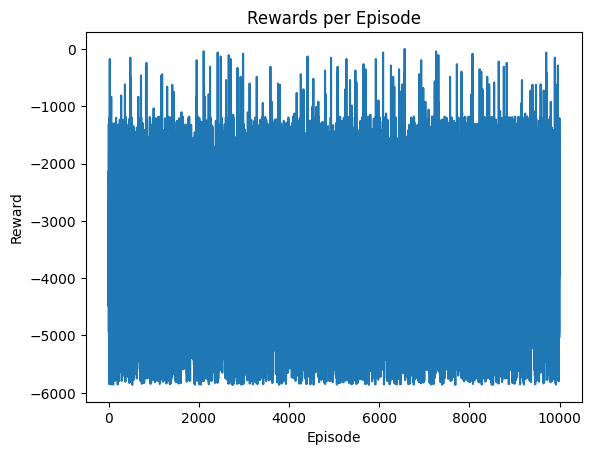

In [934]:

# Set random seed for reproducibility and train the loop
np.random.seed(42)
random.seed(42)
# Initialize a list to store rewards per episode
rewards_per_episode = []

for episode in tqdm(range(n_episodes), desc="evaluating results per episode ..."):
    current_state = np.random.randint(0, n_states)  # Random initial state
    total_reward = 0  # Initialize total reward for the current episode

    while current_state < n_states - 1:
        action = choose_action(current_state, epsilon)
        
        next_state = current_state + 1  # This depends on your environment logic
        reward = rewards[next_state]

        best_next_action = np.argmax(q_table[next_state])
        q_table[current_state, action] += alpha * (
            reward + gamma * q_table[next_state, best_next_action] - q_table[current_state, action]
        )
        
        total_reward += reward  # Accumulate reward for the current episode
        current_state = next_state  # Move to next state

    rewards_per_episode.append(total_reward)  # Store the total reward for the current episode

    # Decay epsilon
    epsilon = max(min_epsilon, epsilon * decay_rate)

    # Optional: Log progress
    if episode % 400 == 0:  # Adjust logging frequency as needed
        print(f"Episode {episode}/{n_episodes} - Total Reward: {total_reward}, Epsilon: {epsilon}")

# Example: Save the Q-table
np.save("small_q_table.npy", q_table)

# Example: Plotting the rewards
import matplotlib.pyplot as plt

plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards per Episode')
plt.show()


In [935]:
def load_q_table(file_path):
    return np.load(file_path)

def load_state_index_mapping(file_path):
    return np.load(file_path, allow_pickle=True).item()

loaded_mapping = load_state_index_mapping(file_path="small_state_to_index.npy")
loaded_qtable = load_q_table(file_path="small_q_table.npy")

In [936]:
def prep_state(sma_05: float, sma_07: float, sma_25: float, sma_compare: int, is_short: int):
    state = np.array([[sma_05, sma_07, sma_25, sma_compare, is_short]])
    if not np.all(np.isfinite(state)):
        state = np.nan_to_num(state, nan=0.0, posinf=0.0, neginf=0.0)
    return state



In [937]:

def predict_action(state, q_table, state_to_index, action_mapping, default_action: str = None):
    state_tuple = tuple(state.flatten())

    state_index = state_to_index.get(state_tuple, -1)

    if not state_index == -1:
        try:
            q_values = q_table[state_index]
        except ValueError as e:
            print(e)
            #return default_action
    else:
        state_tuples = list(state_to_index.keys())
        kdtree = KDTree(state_tuples)
        distance, index = kdtree.query(state.flatten())
        nearest_state_tuple = state_tuples[index]
        new_state_index = loaded_state_to_index[nearest_state_tuple]
        q_values = loaded_qtable[new_state_index]
    
    #q_values = q_table[state_index]
    best_action_index = np.argmax(q_values)
    action = [action for action, index in action_mapping.items() if index == best_action_index][0]
    return action


In [938]:
# Example usage:
with open("small_q_table.npy", "rb") as f:
    q_table = load_q_table("small_q_table.npy")

with open("small_state_to_index.npy", "rb") as f:
    state_to_index = load_state_index_mapping("small_state_to_index.npy")

X = train_data[["sma-05", "sma-07", "sma-25", "sma-compare", "is_short"]].values
state_1 = list(X[-1:].flatten()) # sample: [[0.87024    0.85277143 0.779504   0.         1.        ]]

state = prep_state(*state_1)
action_mapping = {"go_long": 0, "go_short": 1, "do_nothing": 2}

try:
    predicted_action = predict_action(state, q_table, state_to_index, action_mapping)
    print(f"The predicted action for the state is: {predicted_action}")
except ValueError as e:
    print(e)
    print("The state is not found in the state index mapping.")

The predicted action for the state is: go_long


In [939]:
# Predict an entire range
for idx, row in train_data.iterrows():
    state = row[["sma-05", "sma-07", "sma-25", "sma-compare", "is_short"]].values
    action = predict_action(state, q_table, state_to_index, action_mapping)
    train_data.loc[idx, "predicted_action"] = action

In [940]:
train_data.head(15)

,Unnamed:,sma-05,sma-07,sma-25,sma-compare,is_short,action,imit-action,nlpreds,reward,action_num,predicted_action
0,0,0.008822,0.008803,0.008324,0,0,go_short,go_long,go_short,0.500560,1,go_long
1,1,0.009810,0.009803,0.009696,0,0,go_short,go_long,go_short,0.374019,1,do_nothing
2,2,0.009770,0.009767,0.009703,0,0,go_short,go_long,go_short,0.629307,1,go_short
3,3,0.009914,0.009921,0.010024,1,0,go_short,go_long,go_short,0.310551,1,go_long
4,4,0.010094,0.010069,0.009925,0,0,go_short,go_long,go_short,0.425579,1,go_short
5,5,0.010154,0.010110,0.009928,0,0,go_short,go_long,go_short,0.292980,1,do_nothing
6,6,0.009348,0.009391,0.009317,0,0,go_short,go_long,go_short,0.411405,1,do_nothing
7,7,0.009188,0.009200,0.008895,0,0,go_short,go_long,go_short,0.272332,1,do_nothing
8,8,0.008692,0.008640,0.008107,0,0,go_short,go_long,go_short,0.715868,1,do_nothing
9,9,0.007502,0.007461,0.007459,0,0,go_short,go_long,go_short,0.291394,1,do_nothing


In [941]:
train_data['predicted_action'].value_counts()

predicted_action
go_long       2834
go_short       852
do_nothing     830
Name: count, dtype: int64

In [942]:
m = train_data[(train_data['predicted_action'] == 'do_nothing') & (train_data['reward'] > 0)]

In [943]:
m['is_short'].value_counts()

is_short
1    809
0     16
Name: count, dtype: int64

In [944]:
# Performance measures
# Initialize cumulative rewards
cumulative_predicted_reward = 0
cumulative_actual_reward = 0

# Iterate through states to calculate rewards
for state_index in range(n_states - 1):
    # Predicted action from Q-table
    predicted_action = np.argmax(q_table[state_index])  # Best action for the current state
    # Actual action from the ground truth
    actual_action = train_data["action_num"].iloc[state_index]

    # Get reward for predicted action only if it matches the actual action
    if predicted_action == actual_action:
        predicted_reward = rewards[state_index + 1]  # Reward for the correct prediction
        cumulative_predicted_reward += predicted_reward

    # Get actual reward for the ground truth action
    actual_reward = rewards[state_index + 1]
    cumulative_actual_reward += actual_reward

    # Optional: Log progress
    if state_index % 100 == 0:  # Adjust logging frequency as needed
        print(f"Processed state {state_index}/{n_states - 1}")
        print(f"Current Predicted Reward: {cumulative_predicted_reward}")
        print(f"Current Actual Reward: {cumulative_actual_reward}")

# Print results
print(f"Cumulative Predicted Reward: {cumulative_predicted_reward}")
print(f"Cumulative Actual Reward: {cumulative_actual_reward}")

# Optionally calculate efficiency
efficiency = (
    ((cumulative_predicted_reward - cumulative_actual_reward) / abs(cumulative_actual_reward)) * 100
    if cumulative_actual_reward != 0
    else 0
)

print(f"Prediction Efficiency: {efficiency:.2f}%")



Processed state 0/4515
Current Predicted Reward: 0
Current Actual Reward: 0.3740187
Processed state 100/4515
Current Predicted Reward: 13.791851409999996
Current Actual Reward: 126.57750178000002
Processed state 200/4515
Current Predicted Reward: 57.65857689
Current Actual Reward: 249.92935686000013
Processed state 300/4515
Current Predicted Reward: 94.38070169999999
Current Actual Reward: 360.1778751300001
Processed state 400/4515
Current Predicted Reward: 109.63133687
Current Actual Reward: 452.9399139999999
Processed state 500/4515
Current Predicted Reward: 130.89872472000002
Current Actual Reward: 562.4116919599994
Processed state 600/4515
Current Predicted Reward: 165.18169723
Current Actual Reward: 665.6769238199989
Processed state 700/4515
Current Predicted Reward: 196.58249895
Current Actual Reward: 770.7745890399988
Processed state 800/4515
Current Predicted Reward: 219.15630374000003
Current Actual Reward: 867.4718461599988
Processed state 900/4515
Current Predicted Reward: 2

In [945]:
# Accuracy
correct_predictions = 0
for state_index in range(n_states):
    predicted_action = np.argmax(q_table[state_index])  # Predicted action
    actual_action = train_data["action_num"].iloc[state_index]  # Actual action
    if predicted_action == actual_action:
        correct_predictions += 1

accuracy = correct_predictions / n_states
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 18.16%


In [946]:
# Confusion matrix
y_true = train_data["action_num"]  # Actual actions
y_pred = [np.argmax(q_table[state_index]) for state_index in range(n_states)]  # Predicted actions

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[   0    0    0]
 [ 188    6   16]
 [2646  846  814]]


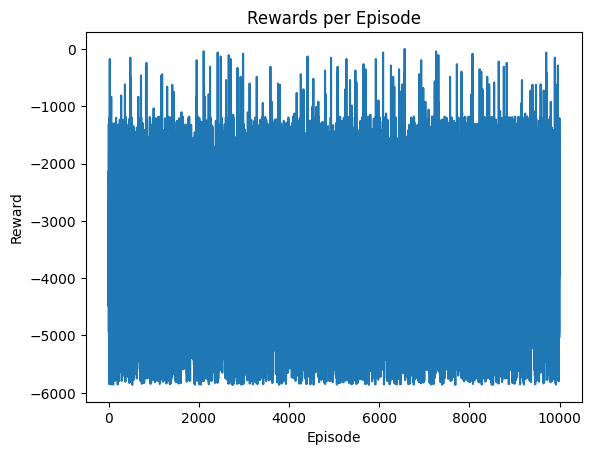

In [947]:
import matplotlib.pyplot as plt

# Assuming you have a list of rewards for each episode
#rewards_per_episode = [...]  # Populate this with your actual data

plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards per Episode')
plt.show()


In [948]:
# Tuning

def train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards):
    q_table = np.zeros((n_states, n_actions))
    rewards_per_episode = []

    for episode in range(n_episodes):
        current_state = np.random.randint(0, n_states)
        total_reward = 0

        while current_state < n_states - 1:
            if np.random.uniform(0, 1) < epsilon:
                action = np.random.randint(0, n_actions)
            else:
                action = np.argmax(q_table[current_state])

            next_state = current_state + 1  # Adjust based on environment logic
            reward = rewards[next_state]

            best_next_action = np.argmax(q_table[next_state])
            q_table[current_state, action] += alpha * (
                reward + gamma * q_table[next_state, best_next_action] - q_table[current_state, action]
            )

            total_reward += reward
            current_state = next_state

        rewards_per_episode.append(total_reward)
        epsilon = max(min_epsilon, epsilon * decay_rate)

    return q_table, rewards_per_episode


In [949]:

def evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards):
    correct_predictions = 0
    total_reward = 0
    reward_weighted_accuracy = []

    for state_index in range(n_states):
        predicted_action = np.argmax(q_table[state_index])  # Predicted action
        actual_action = train_data["action_num"].iloc[state_index]  # Actual action
        reward = rewards[state_index]  # Reward for the action

        if predicted_action == actual_action:
            correct_predictions += 1
            total_reward += reward

        accuracy = correct_predictions / (state_index + 1)
        reward_weighted_accuracy.append(total_reward / (state_index + 1))

        # Optional: Log progress
        if state_index % 100 == 0:
            print(f"Processed state {state_index}/{n_states} - Accuracy: {accuracy * 100:.2f}%, Reward-weighted Accuracy: {reward_weighted_accuracy[-1]}")

    final_reward_weighted_accuracy = total_reward / n_states
    return final_reward_weighted_accuracy * 100



In [950]:
'''
def random_search_reward_weighted(n_iter, param_grid, n_states, n_actions, rewards, train_data):
    best_params = None
    best_reward_weighted_accuracy = float('-inf')

    for _ in tqdm(range(n_iter), desc="Searching for params ..."):
        alpha = random.choice(param_grid['alpha'])
        gamma = random.choice(param_grid['gamma'])
        epsilon = random.choice(param_grid['epsilon'])
        min_epsilon = random.choice(param_grid['decay_rate'])
        decay_rate = random.choice(param_grid['decay_rate'])
        n_episodes = random.choice(param_grid['n_episodes'])

        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)
        reward_weighted_accuracy = evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards)

        if reward_weighted_accuracy > best_reward_weighted_accuracy:
            best_reward_weighted_accuracy = reward_weighted_accuracy
            best_params = (alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes)

        print(f"Iteration Reward-weighted Accuracy: {reward_weighted_accuracy:.2f}%, Best Reward-weighted Accuracy: {best_reward_weighted_accuracy:.2f}%")

    return best_params, best_reward_weighted_accuracy

# Define the parameter grid
param_grid = {
    'alpha': [0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.5, 0.7, 0.9, 1],
    'gamma': [0.75, 0.85, 0.9, 0.95, 0.99],
    'epsilon': [1.0, 0.5, 0.1, 0.05, 0.01],
    'min_epsilon': [0.05, 0.01, 0.005, 0.001, 0.001],
    'decay_rate': [0.95, 0.96, 0.97, 0.99, 0.995, 0.997, 0.999],
    'n_episodes': [8000, 9000, 10000, 11000, 12000, 15000, 18000, 21000]
}

# Perform Random Search
best_params, best_reward_weighted_accuracy = random_search_reward_weighted(50, param_grid, n_states, n_actions, rewards, train_data)
print(f"Best Hyperparameters: {best_params}")
print(f"Best Reward-weighted Accuracy: {best_reward_weighted_accuracy:.2f}%")

'''

'\ndef random_search_reward_weighted(n_iter, param_grid, n_states, n_actions, rewards, train_data):\n    best_params = None\n    best_reward_weighted_accuracy = float(\'-inf\')\n\n    for _ in tqdm(range(n_iter), desc="Searching for params ..."):\n        alpha = random.choice(param_grid[\'alpha\'])\n        gamma = random.choice(param_grid[\'gamma\'])\n        epsilon = random.choice(param_grid[\'epsilon\'])\n        min_epsilon = random.choice(param_grid[\'decay_rate\'])\n        decay_rate = random.choice(param_grid[\'decay_rate\'])\n        n_episodes = random.choice(param_grid[\'n_episodes\'])\n\n        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)\n        reward_weighted_accuracy = evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards)\n\n        if reward_weighted_accuracy > best_reward_weighted_accuracy:\n            best_reward_weighted_accuracy = reward_weighted_accuracy\n        